### Run the Code with "Shift+Enter"

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### List out all .csv files in this directory

In [2]:
files = glob('*.csv') + glob('*.txt')
files

['sample_pvsyst_file.CSV', 'readme.txt', 'sample_energy_logger_file.txt']

### Set Input Filename

In [3]:
# PVsyst filename
INPUT_FILE = 'sample_pvsyst_file.CSV'
# Energy logger filename
LOGGER_FILE = 'sample_energy_logger_file.txt'

### Set Output Filename. It will save in the same directory

In [4]:
COMPANY     = 'SAMPLE'
CAPACITY    = '%.3f' % 120.950
DESC	    = ''
OUTPUT_FILE = 'energy_graph_load_profile_'+COMPANY+'_'+CAPACITY+'kwp'+DESC+'.xlsx'
print(OUTPUT_FILE)

energy_graph_load_profile_SAMPLE_120.950kwp.csv


### Choose which day for PVsyst, leave `DAYS` blank to select whole week

In [5]:
DAYS = ['Friday', 'Saturday', 'Sunday', 'Monday'] # output will follow this order
# [] means whole week or 7 days
WEEK = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

if len(DAYS)==0:
    sorterIndex = dict(zip(WEEK, range(len(WEEK))))    
else:
    sorterIndex = dict(zip(DAYS, range(len(DAYS))))

### Process PVsyst data - Choose groupby Max or Mean

In [6]:
COLUMN_NAME = ['date','EOutInv']

data = pd.read_csv(INPUT_FILE, skiprows=13, names=COLUMN_NAME, delimiter=';')
data['datetime'] = pd.to_datetime(data.date, format='%d/%m/%y %H:%M')
data1 = data[['datetime','EOutInv']].copy()
data1['hour'] = data1.datetime.apply(lambda x: x.hour)
data1['weekday'] = data1.datetime.apply(lambda x: x.day_name())
data1 = data1 if len(DAYS)==0 else data1[data1.weekday.isin(DAYS)]
print(data1.shape)

data2 = data1.groupby(['weekday','hour']).agg({'EOutInv':'mean'}).reset_index().copy()
data2['rank'] = data2['weekday'].map(sorterIndex)
data2.sort_values(['rank','hour'], inplace=True)
data2.reset_index(drop=True, inplace=True)
data2.drop('rank', axis=1, inplace=True)
print(data2.shape)

(5016, 4)
(96, 3)


### Process Energy Logger data
- Manually set the start & end date
- `PowerP_Total_avg` W
- `ActiveEnergy_Total_avg` Wh

In [7]:
logger = pd.read_csv(LOGGER_FILE, delimiter=';')
print(logger.shape)

(1427, 16)


In [93]:
START_DATE = '2022-08-03'
END_DATE = '2022-08-07' # Add 1 day extra
DATE_COL = ['Start(Malay Peninsula Standard Time)', 'Stop(Malay Peninsula Standard Time)']
VOL_COL = ['Vrms_AN_max', 'Vrms_BN_max', 'Vrms_CN_max']
AMP_COL = ['Irms_A_max', 'Irms_B_max', 'Irms_C_max']
PWR_COL = ['PowerP_A_max', 'PowerP_B_max', 'PowerP_C_max', 'PowerP_Total_max']
LOGGER_COL = DATE_COL + VOL_COL + AMP_COL + PWR_COL
    
logger = pd.read_csv(LOGGER_FILE, delimiter=';')
print(logger.shape)

logger1 = logger[LOGGER_COL].copy()
logger1['Start(Malay Peninsula Standard Time)'] =  pd.to_datetime(logger1.iloc[:, 0], format='%Y-%m-%d %H:%M:%S.%f').apply(lambda x: x.replace(microsecond=0))
for col in PWR_COL:
    logger1[col] =  logger1[col]/1000 # convert from W to kW & VAr to kVAr
logger1['date'] = logger1.iloc[:, 0].apply(lambda x: x.date())
logger1 = logger1[(logger1.iloc[:, 0] >= START_DATE) & (logger1.iloc[:, 0] < END_DATE)]
logger1['weekday'] = logger1.iloc[:, 0].apply(lambda x: x.day_name())
logger1['hour'] = logger1.iloc[:, 0].apply(lambda x: x.hour)
print(logger1.shape)

(1427, 16)
(1152, 15)


In [97]:
# CALCULATION #1
# agg_dict = {'T_diff': 'sum'}
agg_dict = {}
for col in VOL_COL+AMP_COL+PWR_COL:
    agg_dict.update({col:'mean'})
       
logger2 = logger1.groupby(['date', 'weekday', 'hour'])\
                 .agg(agg_dict)\
                 .reset_index()\
                 .copy()
# logger2 = logger2[logger2.T_diff == 3600].drop(columns=['T_diff'])
print(logger2.shape)

(96, 13)


In [98]:
assert len(data2) == len(logger2), 'Length not match with '+str(len(data2))+' and '+str(len(logger2))
final = pd.merge(logger2, data2, on=['weekday', 'hour'])
print(final.shape)
final.to_csv(OUTPUT_FILE, index=False)
final.head(1)

(48, 14)


,date,weekday,hour,Vrms_AN_max,Vrms_BN_max,Vrms_CN_max,Irms_A_max,Irms_B_max,Irms_C_max,PowerP_A_max,PowerP_B_max,PowerP_C_max,PowerP_Total_max,EOutInv
0,2022-08-05,Friday,0,236.9525,236.90825,238.80925,63.805567,65.255858,61.411358,13.303968,13.410877,12.779306,39.49415,-0.0035


### Daytime Peak & Lowest Demand

In [100]:
peak = final[final.hour.isin(range(11,16))]
max_row = peak.PowerP_Total_max.idxmax()
peak = np.round(peak.loc[[max_row],'PowerP_Total_max'].values[0], 2)
low = final[final.hour.isin(range(7,22))]
min_row = low.PowerP_Total_max.idxmin()
low = np.round(low.loc[[min_row],'PowerP_Total_max'].values[0], 2)
print(f'Daytime Peak Demand: {peak} kW')
print(f'Daytime Lowest Demand: {low} kW')

Daytime Peak Demand: 63.39 kW
Daytime Lowest Demand: 16.85 kW


### Plot the graph

In [ ]:
nDays = final.date.nunique()
nInterval = 4 # 4 hours intervals
final['datetime'] = final.apply(lambda x: str(x.date.day).zfill(2)+'/'+str(x.date.month).zfill(2)
                                +' '+str(x.hour).zfill(2)+':00', axis=1)
fig = plt.figure(figsize=(14,10)) # set (width, height)
fig.patch.set_facecolor('white')
# plt.plot(final.index, final.EOutInv, label='Inverter Generation')
plt.plot(final.index, final[PWR_COL[-1]], label='Load Profile')
plt.title('Load Profile for \n'+COMPANY+'_'+str(CAPACITY).zfill(3)
          +'kwp \nfrom '+str(final.date.values[0])+' to '+str(final.date.values[-1]), fontsize=16, linespacing=2)
plt.xlabel('Datetime', fontsize=16)
last_label = pd.Series(END_DATE[-2:]+'/'+END_DATE[-5:-3]+' 00:00')
plt.xticks(range(0,24*nDays+1,nInterval), final.datetime[::nInterval].append(last_label), fontsize=14, rotation=70)
# plt.xticks(range(12,108,24), list(sorterIndex.keys()))
plt.ylabel('Power (kW)', fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.show()

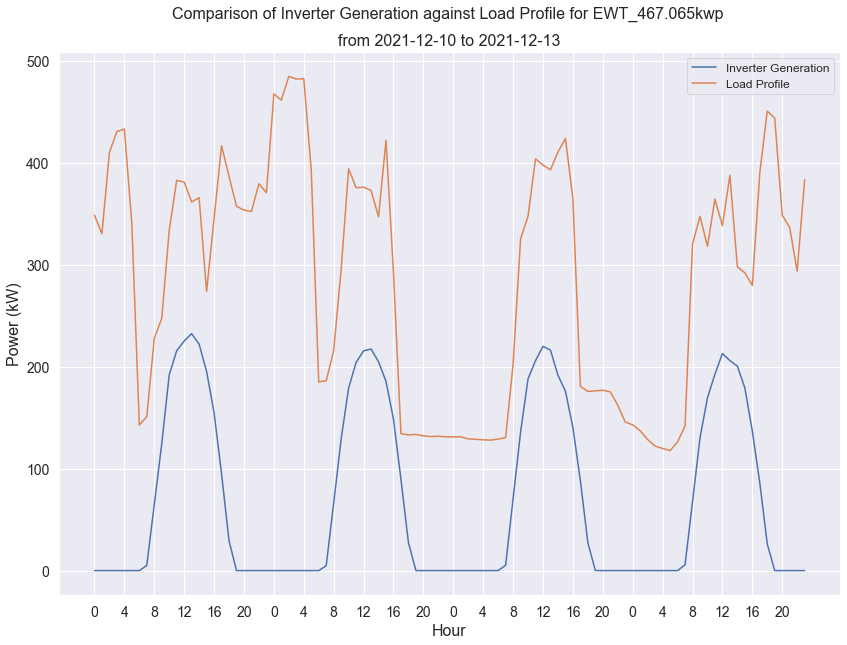

In [18]:
nDays = final.date.nunique()
nInterval = 4 # 4 hours intervals
final['datetime'] = final.apply(lambda x: str(x.date.day).zfill(2)+'/'+str(x.date.month).zfill(2)
                                +' '+str(x.hour).zfill(2)+':00', axis=1)
fig = plt.figure(figsize=(14,10)) # set (width, height)
fig.patch.set_facecolor('white')
plt.plot(final.index, final.EOutInv, label='Inverter Generation')
plt.plot(final.index, final[PWR_COL[-1]], label='Load Profile')
plt.title('Comparison of Inverter Generation against Load Profile for \n'+COMPANY+'_'+str(CAPACITY).zfill(3)
          +'kwp \nfrom '+str(final.date.values[0])+' to '+str(final.date.values[-1]), fontsize=16, linespacing=2)
plt.xlabel('Datetime', fontsize=16)
last_label = pd.Series(END_DATE[-2:]+'/'+END_DATE[-5:-3]+' 00:00')
plt.xticks(range(0,24*nDays+1,nInterval), final.datetime[::nInterval].append(last_label), fontsize=14, rotation=70)
# plt.xticks(range(12,108,24), list(sorterIndex.keys()))
plt.ylabel('Power (kW)', fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.show()